In [1]:
'''
CREDITS TO: https://github.com/gurkandemir/Bag-of-Visual-Wordsimport
The original code only used SIFT descriptors.
The following code uses also Harris corners detector and BRISK.
The general algorithm's pipeline is the same as the original one.
I have added a "mode" attribute to the "execute" method to switch between SIFT/Harris/BRISK:
they all use a different "getDescriptors" function
SIFT -> getDescriptors_SIFT
Harris -> getDescriptors_Harris
BRISK -> getDescriptors_BRISK
Also, the features are accordingly reshaped.
'''

import cv2
import numpy as np 
import os
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics.pairwise import chi2_kernel
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [2]:
def getFiles(train, path):
    images = []
    count = 0
    for folder in os.listdir(path):
        for file in  os.listdir(path +'/'+ folder):
            images.append(path+'/' + folder  + '/'+  file)
    if(train is True):
        np.random.shuffle(images)
    return images

In [3]:
# Compute SIFT descriptors and keypoints
def getDescriptors_SIFT(img):
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    return des, kp

# Compute Harris corners
def getDescriptors_Harris(img):
    corners = cv2.cornerHarris(img, 5, 3, 0.04)
    corners = cv2.dilate(corners, None)
    _, corners = cv2.threshold(corners, 0.01*corners.max(), 255, 0)
    corners = np.uint8(corners)
    return corners

# Compute BRISK descriptors and keypoints
def getDescriptors_BRISK(img):
    brisk = cv2.BRISK_create(30)
    kpts, dst = brisk.detectAndCompute(img, None)
    return dst, kpts

def readImage(img_path):
    img = cv2.imread(img_path, 0)
    return cv2.resize(img,(150,150))

def vstackDescriptors(descriptor_list):
    descriptors = np.array(descriptor_list[0])
    for descriptor in descriptor_list[1:]:
        descriptors = np.vstack((descriptors, descriptor)) 
    return descriptors

In [4]:
def clusterDescriptors(descriptors, no_clusters):
    kmeans = KMeans(n_clusters = no_clusters).fit(descriptors)
    return kmeans

def extractFeatures(kmeans, descriptor_list, image_count, no_clusters, mode):
    im_features = np.array([np.zeros(no_clusters) for i in range(image_count)])
    for i in range(image_count):
        for j in range(len(descriptor_list[i])):
            feature = descriptor_list[i][j]
            if (mode == 'sift'):
                feature = feature.reshape(1, 128)
            if (mode == 'harris'):
                feature = feature.reshape(1, 150)
            if (mode == 'brisk'):
                feature = feature.reshape(1, 64)
            idx = kmeans.predict(feature)
            im_features[i][idx] += 1
    return im_features

def normalizeFeatures(scale, features):
    return scale.transform(features)

def plotHistogram(im_features, no_clusters):
    x_scalar = np.arange(no_clusters)
    y_scalar = np.array([abs(np.sum(im_features[:,h], dtype=np.int32)) for h in range(no_clusters)])
    plt.bar(x_scalar, y_scalar)
    plt.xlabel("Visual Word Index")
    plt.ylabel("Frequency")
    plt.title("Complete Vocabulary Generated")
    plt.xticks(x_scalar + 0.4, x_scalar)
    plt.show()

def svcParamSelection(X, y, kernel, nfolds):
    Cs = [0.5, 0.1, 0.15, 0.2, 0.3]
    gammas = [0.1, 0.11, 0.095, 0.105]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel=kernel), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

def findSVM(im_features, train_labels, kernel):
    features = im_features
    if(kernel == "precomputed"):
        features = np.dot(im_features, im_features.T)
    params = svcParamSelection(features, train_labels, kernel, 5)
    C_param, gamma_param = params.get("C"), params.get("gamma")
    print(C_param, gamma_param)
    class_weight = {
        0: (807 / (7 * 140)),
        1: (807 / (7 * 140)),
        2: (807 / (7 * 133)),
        3: (807 / (7 * 70)),
        4: (807 / (7 * 42)),
        5: (807 / (7 * 140)),
        6: (807 / (7 * 142)) 
    }
    svm = SVC(kernel = kernel, C =  C_param, gamma = gamma_param, class_weight = class_weight)
    svm.fit(features, train_labels)
    return svm

def plotConfusionMatrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def plotConfusions(true, predictions):
    np.set_printoptions(precision=2)
    class_names = ["city", "face", "green", "house_building", "house_indoor", "office", "sea"]
    plotConfusionMatrix(true, predictions, classes=class_names, title='Confusion matrix, without normalization')
    plotConfusionMatrix(true, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()

def findAccuracy(true, predictions):
    print ('accuracy score: %0.3f' % accuracy_score(true, predictions))

In [5]:
def trainModel(path, no_clusters, kernel, mode):
    images = getFiles(True, path)
    print("Train images path detected.")
    descriptor_list = []
    train_labels = np.array([])
    label_count = 7
    image_count = len(images)

    for img_path in images:
        if("city" in img_path):
            class_index = 0
        elif("face" in img_path):
            class_index = 1
        elif("green" in img_path):
            class_index = 2
        elif("house_building" in img_path):
            class_index = 3
        elif("house_indoor" in img_path):
            class_index = 4
        elif("office" in img_path):
            class_index = 5
        else:
            class_index = 6

        train_labels = np.append(train_labels, class_index)
        img = readImage(img_path)
        
        if(mode == 'harris'):
            des = getDescriptors_Harris(img)
        elif(mode == 'brisk'):
            des, _ = getDescriptors_BRISK(img)
        elif(mode == 'sift'):
            des, _ = getDescriptors_SIFT(img)
            
        descriptor_list.append(des)

    descriptors = vstackDescriptors(descriptor_list)
    print("Descriptors vstacked.")

    kmeans = clusterDescriptors(descriptors, no_clusters)
    print("Descriptors clustered.")

    im_features = extractFeatures(kmeans, descriptor_list, image_count, no_clusters, mode)
    print("Images features extracted.")

    scale = StandardScaler().fit(im_features)        
    im_features = scale.transform(im_features)
    print("Train images normalized.")

    plotHistogram(im_features, no_clusters)
    print("Features histogram plotted.")

    svm = findSVM(im_features, train_labels, kernel)
    print("SVM fitted.")
    print("Training completed.")

    return kmeans, scale, svm, im_features

In [6]:
def testModel(path, kmeans, scale, svm, im_features, no_clusters, kernel, mode):
    test_images = getFiles(False, path)
    print("Test images path detected.")

    count = 0
    true = []
    descriptor_list = []

    name_dict =	{
        "0": "city",
        "1": "face",
        "2": "green",
        "3": "house_building",
        "4": "house_indoor",
        "5": "office",
        "6": "sea"
    }

    for img_path in test_images:
        img = readImage(img_path)
        
        if(mode == 'harris'):
            des = getDescriptors_Harris(img)
        elif(mode == 'brisk'):
            des, _ = getDescriptors_BRISK(img)
        elif(mode == 'sift'):
            des, _ = getDescriptors_SIFT(img)

        if(des is not None):
            count += 1
            descriptor_list.append(des)

            if("city" in img_path):
                true.append("city")
            elif("face" in img_path):
                true.append("face")
            elif("green" in img_path):
                true.append("green")
            elif("house_building" in img_path):
                true.append("house_building")
            elif("house_indoor" in img_path):
                true.append("house_indoor")
            elif("office" in img_path):
                true.append("office")
            else:
                true.append("sea")

    descriptors = vstackDescriptors(descriptor_list)

    test_features = extractFeatures(kmeans, descriptor_list, count, no_clusters, mode)

    test_features = scale.transform(test_features)
    
    kernel_test = test_features
    if(kernel == "precomputed"):
        kernel_test = np.dot(test_features, im_features.T)
    
    predictions = [name_dict[str(int(i))] for i in svm.predict(kernel_test)]
    print("Test images classified.")

    plotConfusions(true, predictions)
    print("Confusion matrixes plotted.")

    findAccuracy(true, predictions)
    print("Accuracy calculated.")
    print("Execution done.")

In [7]:
def execute(train_path, test_path, no_clusters, kernel, mode):
    kmeans, scale, svm, im_features = trainModel(train_path, no_clusters, kernel, mode)
    testModel(test_path, kmeans, scale, svm, im_features, no_clusters, kernel, mode)

Train images path detected.
Descriptors vstacked.
Descriptors clustered.
Images features extracted.
Train images normalized.


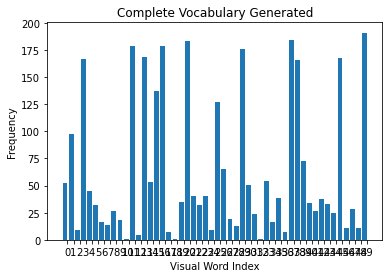

Features histogram plotted.
0.5 0.1
SVM fitted.
Training completed.
Test images path detected.
Test images classified.
Confusion matrix, without normalization
[[17  1  8  2  0  0  2]
 [ 1 20  1  0  8  0  0]
 [ 5  2 19  0  1  1  2]
 [ 4  1  1 16  6  2  0]
 [ 1  1  0  3  7 18  0]
 [ 1  0  2  5  6 16  0]
 [ 2  2  5  0  0  1 19]]
Normalized confusion matrix
[[0.57 0.03 0.27 0.07 0.   0.   0.07]
 [0.03 0.67 0.03 0.   0.27 0.   0.  ]
 [0.17 0.07 0.63 0.   0.03 0.03 0.07]
 [0.13 0.03 0.03 0.53 0.2  0.07 0.  ]
 [0.03 0.03 0.   0.1  0.23 0.6  0.  ]
 [0.03 0.   0.07 0.17 0.2  0.53 0.  ]
 [0.07 0.07 0.17 0.   0.   0.03 0.66]]


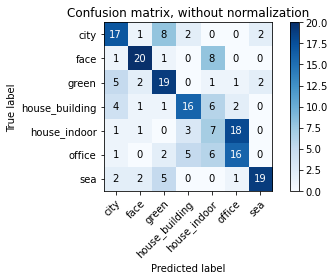

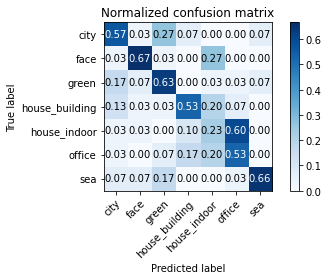

Confusion matrixes plotted.
accuracy score: 0.545
Accuracy calculated.
Execution done.


In [8]:
execute('../../Dataset/train', '../../Dataset/test', 50, 'linear', 'sift')

Train images path detected.
Descriptors vstacked.
Descriptors clustered.
Images features extracted.
Train images normalized.


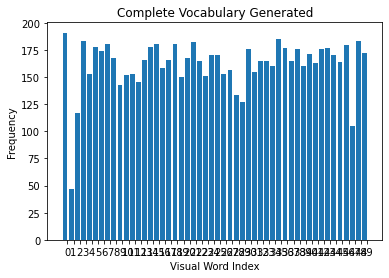

Features histogram plotted.
0.2 0.1
SVM fitted.
Training completed.
Test images path detected.
Test images classified.
Confusion matrix, without normalization
[[23  0  4  0  0  1  2]
 [ 0 24  0  2  2  0  2]
 [ 3  2 13  5  0  5  2]
 [ 5  0  4 11  5  5  0]
 [ 2  3  6  3  9  6  1]
 [ 1  6  2  5  1 12  3]
 [ 4  1  5  1  3  1 15]]
Normalized confusion matrix
[[0.77 0.   0.13 0.   0.   0.03 0.07]
 [0.   0.8  0.   0.07 0.07 0.   0.07]
 [0.1  0.07 0.43 0.17 0.   0.17 0.07]
 [0.17 0.   0.13 0.37 0.17 0.17 0.  ]
 [0.07 0.1  0.2  0.1  0.3  0.2  0.03]
 [0.03 0.2  0.07 0.17 0.03 0.4  0.1 ]
 [0.13 0.03 0.17 0.03 0.1  0.03 0.5 ]]


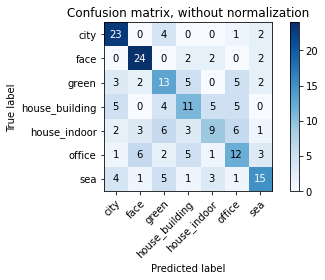

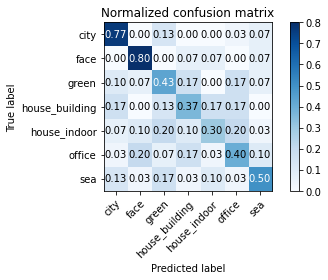

Confusion matrixes plotted.
accuracy score: 0.510
Accuracy calculated.
Execution done.


In [24]:
execute('../../Dataset/train', '../../Dataset/test', 50, 'linear', 'harris')

Train images path detected.
Descriptors vstacked.
Descriptors clustered.
Images features extracted.
Train images normalized.


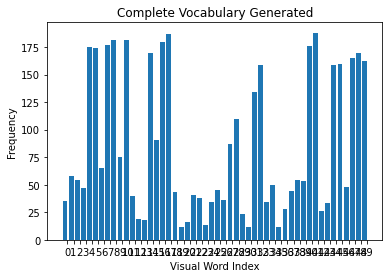

Features histogram plotted.
0.1 0.1
SVM fitted.
Training completed.
Test images path detected.
Test images classified.
Confusion matrix, without normalization
[[16  0  4  2  2  1  5]
 [ 0 23  0  0  2  5  0]
 [ 2  3 12  2  1  2  8]
 [ 1  0  4 14  4  5  2]
 [ 0  3  6  2 10  9  0]
 [ 2  0  4  6  7  9  2]
 [ 4  0  2  0  1  2 21]]
Normalized confusion matrix
[[0.53 0.   0.13 0.07 0.07 0.03 0.17]
 [0.   0.77 0.   0.   0.07 0.17 0.  ]
 [0.07 0.1  0.4  0.07 0.03 0.07 0.27]
 [0.03 0.   0.13 0.47 0.13 0.17 0.07]
 [0.   0.1  0.2  0.07 0.33 0.3  0.  ]
 [0.07 0.   0.13 0.2  0.23 0.3  0.07]
 [0.13 0.   0.07 0.   0.03 0.07 0.7 ]]


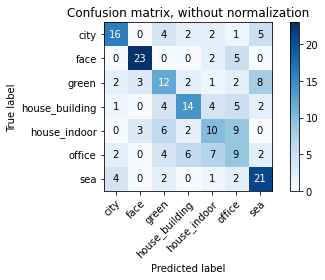

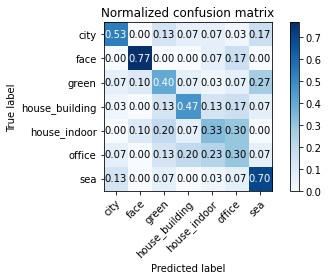

Confusion matrixes plotted.
accuracy score: 0.500
Accuracy calculated.
Execution done.


In [9]:
execute('../../Dataset/train', '../../Dataset/test', 50, 'linear', 'brisk')

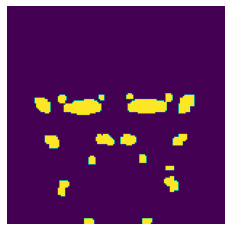

In [9]:
# Features extracted by Harris/BRISK (next cell)/SIFT
# Comparison in pdf
img = cv2.resize(cv2.imread("face-015.jpg", 0), (150,150))
cors = getDescriptors_Harris(img)
plt.axis("off")
cv2.imwrite("10.HarrisFeatures.png", cors)
plt.imshow(cors)

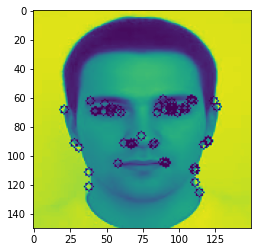

In [7]:
# Features extracted by BRISK
img = cv2.resize(cv2.imread("face-015.jpg", 0), (150,150))
_, keyPoints = getDescriptors_BRISK(img)
for point in keyPoints:
    x = np.int(point.pt[0])
    y = np.int(point.pt[1])
    size = 3 # np.int(point.size)
    cv2.circle(img,(x,y), size, (0,255,0), thickness=1, lineType=8, shift=0) 
cv2.imwrite("10.BRISKfeatures.png", img)
plt.imshow(img)

In [11]:
img = cv2.resize(cv2.imread("face-015.jpg", 0), (150,150))
_, keyPoints = getDescriptors_SIFT(img)
for point in keyPoints:
    x = np.int(point.pt[0])
    y = np.int(point.pt[1])
    size = 3 # np.int(point.size)
    cv2.circle(img,(x,y), size, (0,255,0), thickness=1, lineType=8, shift=0) 
cv2.imwrite("10.SIFTfeatures.png", img)
plt.imshow(img)